# Exercise 4 - Neural Network Learning

## Backpropogation

### Import libraries

In [1]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat

### Read the data

In [2]:
data = loadmat("ex4data1.mat")

X = data["X"]
y = data["y"]

### Visualize the data

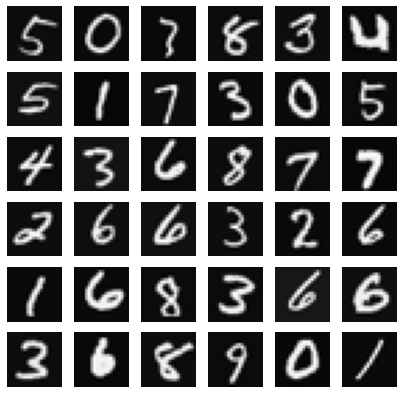

In [3]:
_, plots = plt.subplots(6, 6, figsize = (7, 7))
for i in range(6):
    for j in range(6):
        plots[i, j].imshow(X[np.random.randint(X.shape[0])].reshape((20, 20), order = "F"), cmap = "gray")
        plots[i, j].axis("off")

### Sigmoid function

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Cost function

In [5]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    Theta1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape((hidden_layer_size, input_layer_size + 1), order = "F")
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape((num_labels, hidden_layer_size + 1), order = "F")
    
    m = X.shape[0]
    X = np.insert(X, 0, 1, axis = 1)
    Z2 = X @ Theta1.T
    A2 = sigmoid(Z2)
    A2 = np.insert(A2, 0, 1, axis = 1)
    Z3 = A2 @ Theta2.T
    A3 = sigmoid(Z3)
    
    y_res = np.stack([[x for x in range(1, num_labels + 1)] for _ in range(m)], axis=0)
    y_res = (y_res==y).astype("int")
    
    
    temp1 = np.multiply(y_res, np.log(A3))
    temp2 = np.multiply(1 - y_res, np.log(1 - A3))
    
    J = -np.sum(temp1 + temp2) / m
    
    reg1 = np.sum(np.power(Theta1[:, 1:], 2))
    reg2 = np.sum(np.power(Theta2[:, 1:], 2))
    
    reg = (lmbda / (2 * m)) * (reg1 + reg2)
    
    return (J + reg)


### Sigmoid gradient

In [6]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

### Gradient function

In [7]:
def nnGradientFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    Theta1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape((hidden_layer_size, input_layer_size + 1), order = "F")
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape((num_labels, hidden_layer_size + 1), order = "F")
    
    m = X.shape[0]
    y_res = np.stack([[x for x in range(1, num_labels + 1)] for _ in range(m)], axis=0)
    y = (y_res == y).astype("int")
    
    Delta1 = np.zeros(Theta1.shape)
    Delta2 = np.zeros(Theta2.shape)
    for i in range(m):
        ones = np.ones(1)
        A1 = np.hstack((ones, X[i]))
        Z2 = A1 @ Theta1.T
        A2 = sigmoid(Z2)
        A2 = np.hstack((ones, A2))
        Z3 = A2 @ Theta2.T
        A3 = sigmoid(Z3)
        
        delta3 = (A3 - y[i])[:, np.newaxis]
        delta2 = np.multiply((Theta2.T @ delta3)[1:], sigmoidGradient(Z2)[:, np.newaxis])
        
        Delta2 = Delta2 + delta3 @ A2[:, np.newaxis].T
        Delta1 = Delta1 + delta2 @ A1[:, np.newaxis].T
    
    Delta1 = Delta1 / m
    Delta2 = Delta2 / m
    
    Delta1[:, 1:] = Delta1[:, 1:] + Theta1[:, 1:] * (lmbda / m)
    Delta2[:, 1:] = Delta2[:, 1:] + Theta2[:, 1:] * (lmbda / m)
    return np.hstack((Delta1.ravel(order = "F"), Delta2.ravel(order = "F")))


### Load saved neural network parameters

In [8]:
data = loadmat("ex4weights.mat")

Theta1 = data["Theta1"]
Theta2 = data["Theta2"]

nn_params = np.hstack((Theta1.ravel(order = "F"), Theta2.ravel(order = "F")))

### Compute cost (feedforward)

#### Neural network parameters

In [9]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

#### Cost without regularization

In [10]:
lmbda = 0

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

print("Cost at parameters (loaded from ex4weights): %f " % J)
print("(this value should be about 0.287629)\n")

Cost at parameters (loaded from ex4weights): 0.287629 
(this value should be about 0.287629)



#### Cost with regularization

In [11]:
lmbda = 1

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

print("Cost at parameters (loaded from ex4weights): %f " % J)
print("(this value should be about 0.383770)\n")

Cost at parameters (loaded from ex4weights): 0.383770 
(this value should be about 0.383770)



### Sigmoid gradient checking

In [12]:
g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1])[:, np.newaxis])

print("Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:")
print(g.flatten())
print("(values should be [0.196612 0.235004 0.250000 0.235004 0.196612])\n")

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]
(values should be [0.196612 0.235004 0.250000 0.235004 0.196612])



### Random initialization

In [13]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init

In [14]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# unrolling parameters into a single column vector
initial_nn_params = np.hstack((initial_Theta1.ravel(order = "F"), initial_Theta2.ravel(order = "F")))

### Check backpropogation

#### Numerical gradient

In [15]:
def computeNumericalGradient(J, theta):
    numgrad = np.zeros(theta.shape[0])
    perturb = np.zeros(theta.shape[0])
    e = 1e-4
    for i in range(theta.shape[0]):

        # Set perturbation vector
        perturb[i] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad[i] = (loss2 - loss1) / (2*e)
        perturb[i] = 0
    return numgrad

#### Debug weight initialization

In [16]:
def debugInitializeWeights(fan_out, fan_in):
    W = np.sin([x+1 for x in range(fan_out * (1 + fan_in))]) / 10
    W = W.reshape(fan_out, 1 + fan_in, order = "F")
    return W

#### Check gradient function

In [17]:
def checkNNGradients(lmbda):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    X = debugInitializeWeights(m, input_layer_size - 1)
    y  = (1 + (np.array([x for x in range(1, m + 1)]) % num_labels))[:, np.newaxis]

    nn_params = np.hstack((Theta1.ravel(order = "F"), Theta2.ravel(order = "F")))
    
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    grad = nnGradientFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    
    for i in range(len(numgrad)):
        print("%13.10f %13.10f" % (numgrad[i], grad[i]))
    
    print("The above two columns you get should be very similar")
    print("(Left-Your Numerical Gradient, Right-Analytical Gradient)\n")

    diff = np.linalg.norm((numgrad - grad), ord = 2) / np.linalg.norm((numgrad + grad), ord = 2)
    print("If your backpropagation implementation is correct, then the relative difference will be small (less than 1e-9).")
    print("Relative Difference: %g\n" % diff)


#### Without regularization

In [18]:
lmbda = 0

checkNNGradients(lmbda)

-0.0092782524 -0.0092782524
 0.0088991196  0.0088991196
-0.0083601076 -0.0083601076
 0.0076281355  0.0076281355
-0.0067479837 -0.0067479837
-0.0000030498 -0.0000030498
 0.0000142869  0.0000142869
-0.0000259383 -0.0000259383
 0.0000369883  0.0000369883
-0.0000468760 -0.0000468760
-0.0001750601 -0.0001750601
 0.0002331464  0.0002331464
-0.0002874687 -0.0002874687
 0.0003353204  0.0003353203
-0.0003762156 -0.0003762156
-0.0000962661 -0.0000962661
 0.0001179827  0.0001179827
-0.0001371497 -0.0001371497
 0.0001532471  0.0001532471
-0.0001665603 -0.0001665603
 0.3145449700  0.3145449701
 0.1110565882  0.1110565882
 0.0974006970  0.0974006970
 0.1640908188  0.1640908188
 0.0575736494  0.0575736493
 0.0504575855  0.0504575855
 0.1645679323  0.1645679323
 0.0577867378  0.0577867378
 0.0507530173  0.0507530173
 0.1583393339  0.1583393339
 0.0559235296  0.0559235296
 0.0491620841  0.0491620841
 0.1511275275  0.1511275275
 0.0536967009  0.0536967009
 0.0471456249  0.0471456249
 0.1495683347  0.149

#### With regularization

In [19]:
lmbda = 3

checkNNGradients(3)

debug_J  = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

print("Cost at (fixed) debugging parameters (w/ lambda = %f): %f" % (lmbda, debug_J))
print("(for lambda = 3, this value should be about 0.576051)\n")

-0.0092782524 -0.0092782524
 0.0088991196  0.0088991196
-0.0083601076 -0.0083601076
 0.0076281355  0.0076281355
-0.0067479837 -0.0067479837
-0.0167679797 -0.0167679797
 0.0394334829  0.0394334829
 0.0593355565  0.0593355565
 0.0247640974  0.0247640974
-0.0326881426 -0.0326881426
-0.0601744725 -0.0601744725
-0.0319612287 -0.0319612287
 0.0249225535  0.0249225535
 0.0597717617  0.0597717617
 0.0386410548  0.0386410548
-0.0173704651 -0.0173704651
-0.0575658668 -0.0575658668
-0.0451963845 -0.0451963845
 0.0091458797  0.0091458797
 0.0546101548  0.0546101547
 0.3145449700  0.3145449701
 0.1110565882  0.1110565882
 0.0974006970  0.0974006970
 0.1186826691  0.1186826691
 0.0000381929  0.0000381929
 0.0336926556  0.0336926556
 0.2039871282  0.2039871282
 0.1171482326  0.1171482326
 0.0754801264  0.0754801264
 0.1256980672  0.1256980672
-0.0040758828 -0.0040758828
 0.0169677090  0.0169677090
 0.1763375497  0.1763375497
 0.1131331422  0.1131331423
 0.0861628953  0.0861628953
 0.1322941357  0.132

### Training the neural network

In [20]:
lmbda = 1

def foo(xk):
    if (foo.counter % 10 == 0):
        cost = nnCostFunction(xk, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
        print("Iteration: %3d | Cost: %f" % (foo.counter + 1, cost))
    foo.counter += 1
    
foo.counter = 0

nn_params = opt.fmin_cg(f = nnCostFunction, x0 = initial_nn_params, fprime = nnGradientFunction, args = (input_layer_size, hidden_layer_size, num_labels, X, y, lmbda), maxiter = 50, callback = foo)

Iteration:   1 | Cost: 3.281396
Iteration:  11 | Cost: 1.289006
Iteration:  21 | Cost: 0.715995
Iteration:  31 | Cost: 0.551602
Iteration:  41 | Cost: 0.468917
         Current function value: 0.446234
         Iterations: 50
         Function evaluations: 106
         Gradient evaluations: 106


In [21]:
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, input_layer_size + 1), order = "F")
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], (num_labels, hidden_layer_size + 1), order = "F")

### Accuracy of the model

In [22]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X = np.hstack((ones, X))
    Z2 = X @ Theta1.T
    A2 = sigmoid(Z2)
    A2 = np.hstack((ones, A2))
    Z3 = A2 @ Theta2.T
    A3 = sigmoid(Z3)
    h = (np.argmax(A3, axis = 1) + 1)
    return h
    

In [23]:
pred = predict(Theta1, Theta2, X)

print("Train Accuracy: %5.3f" % (np.mean(pred == y.flatten()) * 100))

Train Accuracy: 96.300


### Visualizing the hidden layer

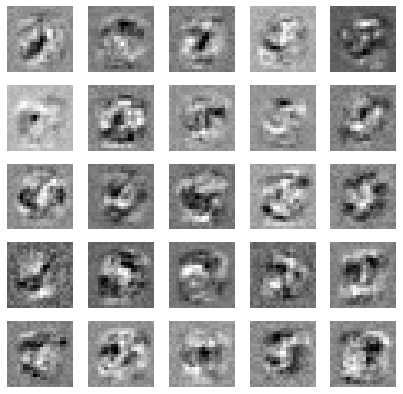

In [24]:
display_theta1 = Theta1[:, 1:]

_, plots_theta = plt.subplots(5, 5, figsize = (7, 7))
for i in range(5):
    for j in range(5):
        plots_theta[i, j].imshow(display_theta1[(i * 5 + j), :].reshape((20, 20), order = "F"), cmap = "gray")
        plots_theta[i, j].axis("off")

### Show some random predictions

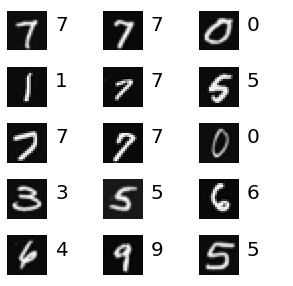

In [25]:
_, pred_plots = plt.subplots(5, 6, figsize = (5, 5))
for i in range(5):
    for j in range(0, 6, 2):
        random_num = np.random.randint(X.shape[0])
        random_X = X[random_num]
        random_pred = pred[random_num] % 10
        
        pred_plots[i, j].imshow(random_X.reshape((20, 20), order = "F"), cmap = "gray")
        pred_plots[i, j].axis("off")
        pred_plots[i, j+1].axis("off")
        pred_plots[i, j+1].text(0, 0.5, str(random_pred), fontsize = 20)
